<a href="https://colab.research.google.com/github/Ranjan83711/Instructional_fine_tuning/blob/main/Instruction_finetuning_on_domain_specific_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pretrain model(LLAMA)

Non-instruction finetuning on plaine text

intruction finetuning on instruciton dataset

prefrence aligment


In [5]:
!pip install -U peft bitsandbytes transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [1]:
!pip install -U trl

In [2]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 41.1 MB/s eta 0:00:00


In [3]:
import fitz

In [4]:
from datasets import Dataset, load_dataset


In [5]:
def extract_text_from_pdf(pdf_path):
    text_blocks = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text = page.get_text("text").strip()
            if text:
                text_blocks.append(text)
    return text_blocks

In [6]:
pdf_texts = extract_text_from_pdf("/content/Prompt Engineering_v4.pdf")

In [7]:
pdf_texts[:5]

['Prompt  \nEngineering\nAuthor: Lee Boonstra',
 'Prompt Engineering\nSeptember 2024\n2\nAcknowledgements\nReviewers and Contributors\nMichael Sherman\nYuan Cao\nErick Armbrust\nAnant Nawalgaria\nAntonio Gulli\nSimone Cammel\nCurators and Editors\nAntonio Gulli\nAnant Nawalgaria\nGrace Mollison \nTechnical Writer\nJoey Haymaker\nDesigner\nMichael Lanning',
 'Introduction\x08\n6\nPrompt engineering\x08\n7\nLLM output configuration\x08\n8\n\t\nOutput length\x08\n8\n\t\nSampling controls\x08\n9\n\t\n\t\nTemperature\t\n9\n\t\n\t\nTop-K and top-P\t\n10\n \n \nPutting it all together\t\n11\nPrompting techniques\x08\n12\n\t\nGeneral prompting / zero shot\x08\n13\n\t\nOne-shot & few-shot\x08\n14\n\t\nSystem, contextual and role prompting\x08\n17\n\t\n\t\nSystem prompting\t\n18\n\t\n\t\nRole prompting\t\n21\n\t\n\t\nContextual prompting\t\n23\nTable of contents',
 'Step-back prompting\x08\n25\n\t\nChain of Thought (CoT)\x08\n29\n\t\nSelf-consistency\x08\n32\n\t\nTree of Thoughts (ToT)\x08\n36\n

In [8]:
import re
def split_paragraphs(pages):
    paragraphs = []
    for page_text in pages:
        # Split on double line breaks or long newlines
        chunks = re.split(r'\n\s*\n', page_text)
        for chunk in chunks:
            clean = chunk.strip()
            if len(clean) > 30:  # ignore too short lines
                paragraphs.append(clean)
    return paragraphs

In [9]:
paragraphs = split_paragraphs(pdf_texts)

In [10]:
data = [{"text": p} for p in paragraphs]

In [11]:
dataset = Dataset.from_list(data)

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset

In [13]:
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [12]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [18]:
def tokenize_fn(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [19]:
tokenized = dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [20]:
tokenized

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 80
})

In [21]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto"
)

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [22]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none"
)

In [23]:
non_inst_model_lora = get_peft_model(model, lora_config)

In [24]:
args = TrainingArguments(
    output_dir="./tinyllama-lora",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)

In [25]:
trainer = Trainer(
    model=non_inst_model_lora,
    args=args,
    train_dataset=tokenized
)

In [26]:
trainer.train()

Step,Training Loss
20,6.206800
40,2.619800


TrainOutput(global_step=50, training_loss=3.8727235794067383, metrics={'train_runtime': 176.261, 'train_samples_per_second': 2.269, 'train_steps_per_second': 0.284, 'total_flos': 1272592937779200.0, 'train_loss': 3.8727235794067383, 'epoch': 5.0})

In [27]:
model_path = "/content/tinyllama-lora/checkpoint-50"

In [28]:
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [29]:
model_path = "/content/checkpoint-50"

first of all lets inspect the data

I am starting with inbuilt data

In [35]:
dataset

Dataset({
    features: ['text'],
    num_rows: 80
})

In [36]:
dataset

Dataset({
    features: ['text'],
    num_rows: 80
})

In [37]:
def format_row(example):
    question = example["Context"]
    answer = example["Response"]
    example["Text"] = f"[INST] {question} [/INST] {answer}"
    return example

In [38]:
def format_row(example):
    question = example["Context"]
    answer = example["Response"]
    example["Text"] = f"[Context] {question} [/Response] {answer}"
    return example

In [62]:
formatted_dataset = dataset.map(format_row)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

KeyError: 'Context'

In [40]:
formatted_dataset

NameError: name 'formatted_dataset' is not defined

In [ ]:
print(formatted_dataset[0]["Text"])

In [41]:
import pandas as pd

# Convert dataset to DataFrame
df = pd.DataFrame(dataset)

In [42]:
df

,text
0,Prompt \nEngineering\nAuthor: Lee Boonstra
1,Prompt Engineering\nSeptember 2024\n2\nAcknowl...
2,Introduction\n6\nPrompt engineering\n7\nLLM ...
3,Putting it all together\t\n11\nPrompting techn...
4,General prompting / zero shot\n13
...,...
75,Prompt Engineering\nSeptember 2024\n61\nExperi...
76,Prompt Engineering\nSeptember 2024\n62\nDocume...
77,Prompt Engineering\nSeptember 2024\n63\nOnce y...
78,Prompt Engineering\nSeptember 2024\n64\n•\t Sy...


In [43]:
df.to_csv("/content/instruction_data_sample.csv", index=False)

In [44]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="/content/instruction_data_sample.csv",split="train")
dataset


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 80
})

till here the data loading part is clear i think

# now lets load our data

In [45]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="/content/instruction_data_sample.csv",split="train")
dataset


Dataset({
    features: ['text'],
    num_rows: 80
})

In [46]:
def format_example(example):
    prompt = f"### Instruction:\n{example['instruction']}\n### Input:\n{example['input']}\n### Response:\n{example['output']}"
    return {"text": prompt}

In [47]:
dataset = dataset.map(format_example)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

KeyError: 'instruction'

In [48]:
dataset

Dataset({
    features: ['text'],
    num_rows: 80
})

In [49]:
dataset['text'][0]

'Prompt  \nEngineering\nAuthor: Lee Boonstra'

### Instruction:\nExplain the mechanism of action of Metformin.\n### Input:\nNone\n### Response:\nMetformin activates AMP-activated protein kinase (AMPK), which increases glucose uptake and fatty-acid oxidation while inhibiting hepatic gluconeogenesis, thereby lowering blood glucose.

In [50]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [51]:
def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [52]:
tokenized = dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [53]:
from peft import LoraConfig, get_peft_model, TaskType

| Parameter        | Meaning                     | Typical Value         | Effect                           |
| ---------------- | --------------------------- | --------------------- | -------------------------------- |
| `task_type`      | Model type (Causal/Seq2Seq) | `CAUSAL_LM`           | Ensures correct integration      |
| `r`              | Rank of LoRA matrix         | 4–16                  | Controls trainable param size    |
| `lora_alpha`     | Scaling factor              | 16–64                 | Balances adaptation strength     |
| `lora_dropout`   | Dropout probability         | 0.05                  | Regularization                   |
| `target_modules` | Which layers to tune        | `["q_proj","v_proj"]` | Trade-off between cost & quality |
| `bias`           | Bias fine-tuning            | `"none"`              | Keep simple                      |


In [54]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none"
)

In [55]:
instruction_model = get_peft_model(non_instruction_model, lora_config)

NameError: name 'non_instruction_model' is not defined

In [ ]:
# #STEP A: Load base model
# model = AutoModelForCausalLM.from_pretrained(...)
# #STEP B: Load Stage-1 LoRA
# model = PeftModel.from_pretrained(model, non_instruction_model)
# model = model.merge_and_unload()
# # Why merge?
# # → Model clean + LoRA applied inside weights
# # → Now you can attach SECOND LoRA cleanly
# #STEP C: Attach NEW LoRA for instruction
# instruction_model_lora = get_peft_model(model, lora_config)

In [56]:
args = TrainingArguments(
    output_dir="./tinyllama-instruction",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)


In [60]:
trainer = Trainer(
    model=tinyllama-lora,
    args=args,
    train_dataset=tokenized,
)

NameError: name 'tinyllama' is not defined

In [61]:
trainer.train()

Step,Training Loss
20,1.263400
40,1.145500


TrainOutput(global_step=50, training_loss=1.1875670051574707, metrics={'train_runtime': 212.6309, 'train_samples_per_second': 1.881, 'train_steps_per_second': 0.235, 'total_flos': 1272592937779200.0, 'train_loss': 1.1875670051574707, 'epoch': 5.0})

In [ ]:
model_path = "/content/tinyllama-instruction/checkpoint-3"

In [ ]:
instruction_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [ ]:
prompt = "Explain the mechanism of action of Metformin."

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

In [ ]:
outputs = instruction_model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

In [ ]:
print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

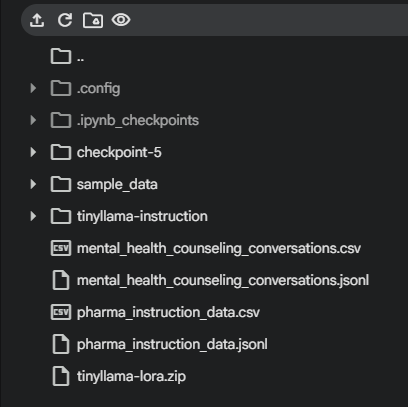

In [63]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import torch

# Load dataset
dataset = load_dataset("csv", data_files="/content/Prompt Engineering_v4.pdf", split="train")
print(dataset)


# Format dataset to Alpaca-style text
def format_example(example):
    # Build unified instruction-style prompt
    prompt = f"### Instruction:\n{example['instruction']}\n### Input:\n{example['input']}\n### Response:\n{example['output']}"
    return {"text": prompt}

dataset = dataset.map(format_example)
print(dataset[0]["text"])


# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


# Tokenization with Response Masking
def tokenize_and_mask(example):
    text = example["text"]

    # Tokenize full text
    enc = tokenizer(text, truncation=True, padding="max_length", max_length=512)
    input_ids = enc["input_ids"]

    # Find where '### Response:' starts
    response_marker = "### Response:"
    response_start = text.find(response_marker)

    if response_start != -1:
        # Token index where response begins
        response_token_start = len(tokenizer(text[:response_start])["input_ids"])
    else:
        response_token_start = 0  # if marker not found

    # Clone labels and mask out everything before 'Response'
    labels = input_ids.copy()
    labels[:response_token_start] = [-100] * response_token_start

    enc["labels"] = labels
    return enc

# Apply tokenization
tokenized = dataset.map(tokenize_and_mask, batched=False)
print("Tokenization + masking done.")


# LoRA config
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none"
)


# Load base model (previously non-instructional trained)
non_instructional_trained_model = AutoModelForCausalLM.from_pretrained(
    "path_to_your_non_instruction_model",
    torch_dtype=torch.float16,
    device_map="auto"
)

model = get_peft_model(non_instructional_trained_model, lora_config)

# Training setup
args = TrainingArguments(
    output_dir="./tinyllama-instruction",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized,
)


# Train the model
trainer.train()


# Save & test the model
trainer.save_model("/content/tinyllama-instruction")
tokenizer.save_pretrained("/content/tinyllama-instruction")

# Test generation
trained_model = AutoModelForCausalLM.from_pretrained("/content/tinyllama-instruction", device_map="auto")

prompt = "### Instruction:\nWhat is Ezetimibe?\n### Input:\n\n### Response:\n"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = trained_model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [64]:
questions = [
    "Explain the mechanism of zero shot prompting.",
    "List two advantages of few shot prompting.",
    "Summarize how good prompt helf to increase the accuracy of code."
]

In [ ]:
for q in questions:
    print("Question:", q)
    print("\n--- Non-instruction model ---")
    inputs = tokenizer(q, return_tensors="pt").to("cuda")
    outputs = non_instruction_model.generate(**inputs, max_new_tokens=80)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

    print("\n--- Instruction-tuned model ---")
    prompt = f"### Instruction:\n{q}\n### Input:\n\n### Response:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = instruction_model.generate(**inputs, max_new_tokens=100)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))
    print("="*80, "\n")
